# Imports

In [10]:
from bs4 import BeautifulSoup

import re
import sys
import string
import json

from datetime import datetime
from dateutil.parser import parse

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pdb
from pymongo import MongoClient
from pymongo import InsertOne, DeleteOne, ReplaceOne, UpdateMany, UpdateOne
from pprint import pprint

from nltk.corpus import stopwords
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk.data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import OrderedDict
from nltk.stem.snowball import SnowballStemmer

from sklearn.decomposition import NMF

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Text Cleaning Utilities

In [3]:
def escape_ansi(line):
    ansi_escape = re.compile(r'(\x9B|\x1B\[)[0-?]*[ -\/]*[@-~]+')
    out = ansi_escape.sub('', line).replace('\n',' . ')
    out = re.sub('[%s]' % re.escape(string.punctuation), ' ', out.replace('--',''))
    return out

alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace('\t',' <stop>')
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    sentences = [escape_ansi(s) for s in sentences if len(s)>1]
    return sentences

def clean_text(texts, lancaster=False):
    
    def stem_words(seq):
        
#         print('seq to stem:')
#         print(seq)
        if lancaster:
            st = LancasterStemmer()
            
            stemmed = " ".join([st.stem(w) for w in seq.split()])
#             print(stemmed)
            return stemmed
    
    def process(text):
        
        rep = {"\'": "",
               "\xa0": " ",
               "  ": ' ',
               "\n":".",
               "\t":".",
               "\x97": " "
              }
        rep = OrderedDict((re.escape(k), v) for k, v in rep.items()) 
        pattern = re.compile("|".join(rep.keys()))
        text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
        
        clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        clean_text = clean_text.lower()
        clean_text = re.sub('\w*\d\w*', ' ', clean_text)
#         clean_text = re.sub('[\n|\t]', ' ', clean_text)

        if lancaster:
            return stem_words(clean_text)
        else:
            return clean_text

    if type(texts) == list:
        return [process(t) for t in texts]

    else:
        return process(texts)

# Text Feature Extraction Utilities

In [7]:
def extract_features(corpus, vectorizer=CountVectorizer(stop_words='english')):
    '''
    
    Extract features from corpus, and return dataframe of features.
    
    
    '''
    
    
    
    
    # Count vectorizer on cleaned text
    X = vectorizer.fit_transform(corpus)
    
    features_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()) 
    
    return features_df

def stem_document(document, concat=True):

    st = SnowballStemmer("english")
    output = []

    for word in document.split():
        output += [st.stem(word)]

    if concat:
        output = ' '.join(output)

    return output

# Load Data

In [8]:
# All concatenated / flatted threads of r_polyamory from 2012 and 2019
with open('../data/exports/by_thread/r_poly_2012_and_2019.pkl', 'rb') as file:
    r_poly_threads = pickle.load(file)

# Clean Text

In [67]:
# # Grab datetime series column and export, for reference:
# with open('../data/exports/doc_term/r_polyamory_2012and2019/date_index.pkl', 'wb') as file:
#     pickle.dump(df['date'], file)

In [9]:
df = pd.DataFrame.from_dict(r_poly_threads)
df['cleaned_text'] = df.text_concat.apply(clean_text)

In [ ]:
df['tagged_text'] = df.cleaned_text.apply(nltk.tokenize.word_tokenize)

In [14]:
df['stemmed_text'] = df['cleaned_text'].apply(stem_document)

In [15]:
df['stemmed_text']

0        i'v seen a coupl of post state that sometim po...
1        saw my new guy recent he confess to me halfway...
2        i am m in a poli relationship with a super att...
3        hi all in the communiti this is a strang probl...
4        i actual live polyamori it s work out realli w...
                               ...                        
17498    my so and i live togeth i m a happi secondari ...
17499    delet don t mean to be skeptic but sinc she is...
17500    this is great everi relationship should do som...
17501    titl is pretti much explanatori is there anyth...
17502    that was realli funni thank you for introduc m...
Name: stemmed_text, Length: 17503, dtype: object

# Text Feature Extraction

In [62]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.2, ngram_range=(1,1))
r_poly_features_cv = extract_features(df['cleaned_text'], vectorizer)
r_poly_features_cv.head(1)

,able,actually,advice,ago,agree,aren,ask,asking,away,bad,...,went,wife,won,work,wouldn,wrong,yeah,year,years,yes
0,0,1,2,0,0,1,0,0,0,0,...,0,2,1,0,0,0,0,0,0,0


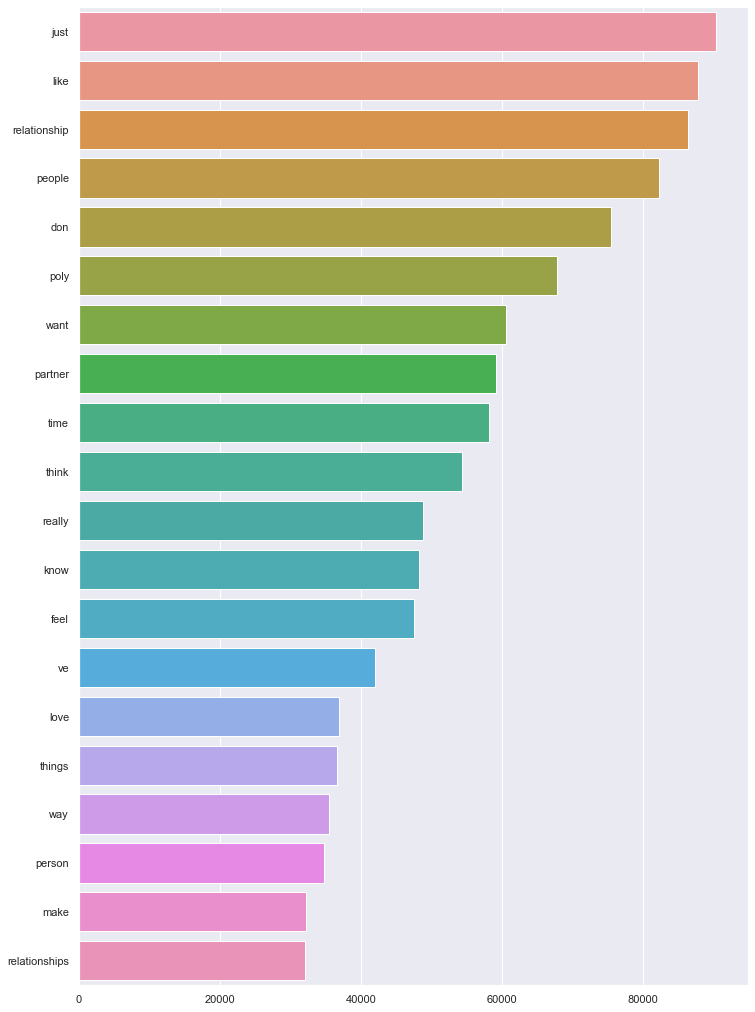

In [63]:
xy = r_poly_features_cv.sum().sort_values(ascending=False)[:20]
token = xy.index
freq = xy.values

fig, ax = plt.subplots(figsize=(12,18))

sns.barplot(x=freq, y=token, orient='h');

In [64]:
CountVectorizer(stop_words='english', min_df=0.1,max_df=0.9, ngram_range=(1,2))
r_poly_features_stemmed_cv = extract_features(df['stemmed_text'], vectorizer)
r_poly_features_stemmed_cv

,abl,accept,actual,advic,ago,agre,alreadi,alway,ani,anoth,...,woman,won,wonder,word,work,wouldn,wrong,yeah,year,yes
0,0,0,1,2,0,0,1,1,3,1,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,2,0,...,0,1,0,1,4,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,1,0,2,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2,0,1,1,0,0
4,1,0,3,1,0,0,1,1,4,1,...,1,0,0,1,5,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17498,1,0,1,6,0,0,2,0,1,2,...,0,0,1,1,3,0,0,0,3,1
17499,0,0,0,1,0,0,0,0,0,0,...,4,0,1,0,1,1,2,0,0,0
17500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17501,1,0,3,0,0,2,0,1,1,1,...,0,2,0,0,3,0,0,1,0,0


In [58]:
r_poly_features_tfidf = extract_features(df['cleaned_text'],
                                         min_df=0.1, max_df=0.9,
                                         model='tfidf', ngram_range=(1,2),
                                        preprocessor=LancasterStemmer)

TypeError: expected string or bytes-like object

In [53]:
pprint(list(r_poly_features_tfidf.columns))

['able',
 'absolutely',
 'accept',
 'act',
 'actually',
 'add',
 'advice',
 'afraid',
 'ago',
 'agree',
 'agreed',
 'allowed',
 'amazing',
 'answer',
 'anymore',
 'appreciate',
 'aren',
 'ask',
 'asked',
 'asking',
 'assume',
 'attention',
 'avoid',
 'aware',
 'away',
 'awesome',
 'bad',
 'based',
 'basically',
 'behavior',
 'believe',
 'best',
 'better',
 'bf',
 'big',
 'bit',
 'boundaries',
 'boyfriend',
 'break',
 'bring',
 'came',
 'care',
 'case',
 'casual',
 'cause',
 'certain',
 'certainly',
 'chance',
 'change',
 'cheating',
 'check',
 'choice',
 'choose',
 'clear',
 'clearly',
 'close',
 'com',
 'come',
 'comes',
 'comfortable',
 'coming',
 'comment',
 'comments',
 'common',
 'communicate',
 'communication',
 'community',
 'completely',
 'connection',
 'consider',
 'continue',
 'control',
 'conversation',
 'cool',
 'couldn',
 'couple',
 'couples',
 'course',
 'current',
 'currently',
 'date',
 'dates',
 'dating',
 'day',
 'days',
 'deal',
 'decide',
 'decided',
 'decision',
 '

In [42]:
sample = df.text_concat.head(1).values[0]

In [54]:
sample

'   I’ve seen a couple of posts stating that sometimes poly isn’t great  Maybe you’re going through a rough patch  or maybe your can’t get a date  Other posts I’ve seen here and other places include people talking about how they can’t do poly any more because someone lied or cheated       The reality is that poly is  always  awesome  but not all people and relationships are  Sometimes we can have a string of relationships that just cause pain  Sometimes we can end up with three consecutive people who just use and abuse us  That’s not poly  The same things can happen in monogamy  Those circumstances arise because of the people involved  or the relationship between certain people  Not everything is going to be perfect  Hell  you may not ever find your subjective “perfect ”      For those of you out there feeling like you’re really upset because you can’t get a date on any of the three dating apps you’re on  or maybe you’re struggling because that someone you’re with just doesn’t seem to 

In [60]:
tokenized = sample
def process_content():
    
    try:
        for i in tokenized.split():
            words = nltk.sent_tokenize(i)
            tagged = nltk.pos_tag(words)
            print(tagged)
            
    except Exception as e:
        print(str(e))
        
process_content()

[('I’ve', 'NN')]
[('seen', 'VBN')]
[('a', 'DT')]
[('couple', 'NN')]
[('of', 'IN')]
[('posts', 'NNS')]
[('stating', 'VBG')]
[('that', 'IN')]
[('sometimes', 'RB')]
[('poly', 'NN')]
[('isn’t', 'NN')]
[('great', 'JJ')]
[('Maybe', 'RB')]
[('you’re', 'NN')]
[('going', 'VBG')]
[('through', 'IN')]
[('a', 'DT')]
[('rough', 'NN')]
[('patch', 'NN')]
[('or', 'CC')]
[('maybe', 'RB')]
[('your', 'PRP$')]
[('can’t', 'NN')]
[('get', 'VB')]
[('a', 'DT')]
[('date', 'NN')]
[('Other', 'JJ')]
[('posts', 'NNS')]
[('I’ve', 'NN')]
[('seen', 'VBN')]
[('here', 'RB')]
[('and', 'CC')]
[('other', 'JJ')]
[('places', 'NNS')]
[('include', 'NN')]
[('people', 'NNS')]
[('talking', 'VBG')]
[('about', 'IN')]
[('how', 'WRB')]
[('they', 'PRP')]
[('can’t', 'NN')]
[('do', 'VB')]
[('poly', 'NN')]
[('any', 'DT')]
[('more', 'RBR')]
[('because', 'IN')]
[('someone', 'NN')]
[('lied', 'VBN')]
[('or', 'CC')]
[('cheated', 'VBN')]
[('The', 'DT')]
[('reality', 'NN')]
[('is', 'VBZ')]
[('that', 'IN')]
[('poly', 'NN')]
[('is', 'VBZ')]
[('al

[('her', 'PRP$')]
[('“poly', 'NN')]
[('is', 'VBZ')]
[('awesome”', 'NN')]
[('Step', 'NN')]
[('off', 'IN')]
[('your', 'PRP$')]
[('soap', 'NN')]
[('box', 'NN')]
[('and', 'CC')]
[('pass', 'NN')]
[('out', 'IN')]
[('more', 'RBR')]
[('kool', 'NN')]
[('aid', 'NN')]


# Document Term Matrix Exports

In [68]:
# def export_document_term_matrix(matrix, ):
suffix = 'r_poly_features_stemmed_cv'
data = r_poly_features_stemmed_cv
filename = '../data/exports/doc_term/r_polyamory_2012and2019/doc_term_'+suffix+'.pkl'

with open(filename, 'wb') as file:
    pickle.dump(data, file)